<H1>Aicha TOUFDRA</H1>

<H1>Prédire le taux de Churn des clients</H1>

**TELCO Inc.** est une entreprise de téléphonie confrontée à un problème de désabonnement (churn). Ils ont collecté un ensemble de données sur leurs anciens clients et vous demandent de :

1. **Classer leurs clients en fonction de la probabilité de désabonnement.**
2. **Déterminer quels clients devraient être contactés et quel devrait être le rabais personnalisé à proposer afin de maximiser le futur profit de TELCO Inc.** (en tenant compte du compromis entre la prévention du désabonnement et la réduction du profit par client après rabais).

**Il y a un coût fixe de 10 € pour contacter un client.**

### Données disponibles

L'ensemble de données contient deux fichiers :

1. **Ensemble d'entraînement** : comprend les étiquettes dans la colonne `CHURNED`.
2. **Ensemble de test** : contient les mêmes colonnes que l'ensemble d'entraînement, mais sans les étiquettes.


<H2>Importation des données</H2>

Import packages

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import plotly.express as px
from sklearn.preprocessing import LabelBinarizer
import matplotlib.ticker as mtick 

import data

In [226]:
train_path = '/home/aicha/Bureau/stage/telco-churn-prediction/data/training.csv'
test_path = '/home/aicha/Bureau/stage/telco-churn-prediction/data/validation.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [227]:
train_df.head()

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,LESSTHAN600k,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,C100000,zero,660.000000,19995.0,0,0,897338.0,False,4,3,160.0,155,1,1.2,15,very_unsat,little,considering,STAY
1,C100001,one,317.647059,31477.0,155,15,393396.0,True,0,1,100.0,245,27,2.7,4,unsat,little,considering,LEAVE
2,C100006,zero,208.695652,66742.0,0,13,937197.0,False,4,2,127.0,493,20,2.6,4,avg,very_little,considering,STAY
3,C100008,zero,265.017668,40864.0,183,0,986430.0,False,3,3,86.0,390,13,2.5,12,unsat,very_high,considering,LEAVE
4,C100010,one,440.000000,43321.5,200,0,394622.0,True,2,3,77.0,175,18,2.4,10,very_unsat,little,actively_looking_into_it,LEAVE


In [228]:
train_df.CONSIDERING_CHANGE_OF_PLAN.values

array(['considering', 'considering', 'considering', ...,
       'actively_looking_into_it', 'considering', 'perhaps'], dtype=object)

In [229]:
train_df.dtypes

CUSTOMER_ID                     object
COLLEGE                         object
DATA                           float64
INCOME                         float64
OVERCHARGE                       int64
LEFTOVER                         int64
HOUSE                          float64
LESSTHAN600k                    object
CHILD                            int64
JOB_CLASS                        int64
REVENUE                        float64
HANDSET_PRICE                    int64
OVER_15MINS_CALLS_PER_MONTH      int64
TIME_CLIENT                    float64
AVERAGE_CALL_DURATION            int64
REPORTED_SATISFACTION           object
REPORTED_USAGE_LEVEL            object
CONSIDERING_CHANGE_OF_PLAN      object
CHURNED                         object
dtype: object

In [230]:
train_df.describe()

,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION
count,11981.000000,11981.000000,11981.000000,11981.000000,11346.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000,11981.000000
mean,503.625376,47595.943703,80.185460,23.785577,506521.681650,2.070194,2.508639,155.541941,383.495868,7.540356,3.079250,5.972957
std,457.156513,22293.736749,84.587419,26.680037,256808.319571,1.249974,1.120546,47.905580,210.601172,8.768863,1.650221,4.361189
min,0.000000,10032.500000,-2.000000,0.000000,150015.000000,0.000000,1.000000,50.000000,130.000000,0.000000,0.300000,1.000000
25%,181.818182,29367.000000,0.000000,0.000000,268511.250000,1.000000,2.000000,121.000000,217.000000,1.000000,1.900000,2.000000
50%,360.995851,44992.500000,56.000000,15.000000,469775.500000,2.000000,3.000000,149.000000,322.000000,4.000000,2.700000,5.000000
75%,685.714286,65078.000000,171.000000,41.000000,722464.250000,3.000000,4.000000,182.000000,515.000000,13.000000,3.800000,9.000000
max,6600.000000,105355.500000,298.000000,89.000000,999996.000000,7.000000,4.000000,521.000000,899.000000,29.000000,21.000000,15.000000


In [231]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CUSTOMER_ID                  11981 non-null  object 
 1   COLLEGE                      11981 non-null  object 
 2   DATA                         11981 non-null  float64
 3   INCOME                       11981 non-null  float64
 4   OVERCHARGE                   11981 non-null  int64  
 5   LEFTOVER                     11981 non-null  int64  
 6   HOUSE                        11346 non-null  float64
 7   LESSTHAN600k                 11346 non-null  object 
 8   CHILD                        11981 non-null  int64  
 9   JOB_CLASS                    11981 non-null  int64  
 10  REVENUE                      11981 non-null  float64
 11  HANDSET_PRICE                11981 non-null  int64  
 12  OVER_15MINS_CALLS_PER_MONTH  11981 non-null  int64  
 13  TIME_CLIENT     

**Ensemble d'entraînement**

- **Nombre d'enregistrements** : 11980
- **Nombre de colonnes** : 18

### Colonnes de l'Ensemble d'Entraînement

1. **Identifiant Client** : `CUSTOMER_ID`
2. **Statut de Désabonnement** : `CHURNED` (étiquette cible)
3. **Caractéristiques Numériques** :
   - `DATA`
   - `INCOME`
   - `OVERCHARGE`
   - `LEFTOVER`
   - `HOUSE`
   - `CHILD`
   - `REVENUE`
   - `HANDSET_PRICE`
   - `OVER_15MINS_CALLS_PER_MONTH`
   - `TIME_CLIENT`
   - `AVERAGE_CALL_DURATION`

4. **Caractéristiques Catégorielles** :
   - `COLLEGE`
   - `JOB_CLASS`
   - `REPORTED_SATISFACTION`
   - `REPORTED_USAGE_LEVEL`
   - `CONSIDERING_CHANGE_OF_PLAN`

In [232]:
train_df.CHURNED.value_counts()

CHURNED
STAY     7612
LEAVE    4369
Name: count, dtype: int64

In [233]:
train_df.JOB_CLASS.value_counts()

JOB_CLASS
4    3045
3    2983
1    2979
2    2974
Name: count, dtype: int64

Les données d'entraînement contiennent plus de clients qui restent que de clients qui quittent.

In [235]:
train_df.isnull().sum()

CUSTOMER_ID                      0
COLLEGE                          0
DATA                             0
INCOME                           0
OVERCHARGE                       0
LEFTOVER                         0
HOUSE                          635
LESSTHAN600k                   635
CHILD                            0
JOB_CLASS                        0
REVENUE                          0
HANDSET_PRICE                    0
OVER_15MINS_CALLS_PER_MONTH      0
TIME_CLIENT                      0
AVERAGE_CALL_DURATION            0
REPORTED_SATISFACTION            0
REPORTED_USAGE_LEVEL             0
CONSIDERING_CHANGE_OF_PLAN       0
CHURNED                          0
dtype: int64

<Axes: >

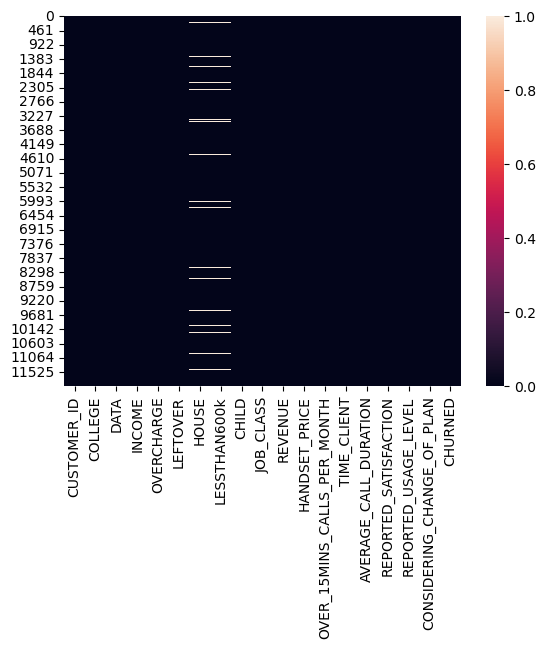

In [236]:
sns.heatmap(train_df.isnull())

La colonne `HOUSE` et  `LESSTHAN600k` ont des valeurs manquantes

In [237]:
train_df['HOUSE'].fillna(train_df['HOUSE'].median(), inplace=True)

Pour traiter les valeurs manquantes dans la colonne HOUSE en utilisant la médiane,

In [238]:
train_df['LESSTHAN600k'].fillna(train_df['LESSTHAN600k'].mode()[0], inplace=True)

Pour traiter les valeurs manquantes dans la colonne LESSTHAN600k en utilisant la valeur modale (la valeur la plus fréquente)

In [239]:
# Calculer le Z-score pour chaque colonne
from scipy import stats
z_scores = stats.zscore(train_df.select_dtypes(include=[float, int]))

# Définir un seuil pour considérer une valeur comme aberrante
threshold = 3
outliers = (abs(z_scores) > threshold).any(axis=1)

# Filtrer les valeurs aberrantes
outlier_rows = train_df[outliers]
print(outlier_rows)

      CUSTOMER_ID COLLEGE         DATA   INCOME  OVERCHARGE  LEFTOVER  \
30        C100044    zero  2880.000000  67189.5           0        15   
46        C100071     one  1320.000000  50355.0           0         0   
62        C100091     one  1920.000000  62502.5           0         0   
106       C100151    zero   920.000000  23701.5           0         5   
165       C100227    zero  1197.879859  57654.0         183         0   
...           ...     ...          ...      ...         ...       ...   
11869     C115821     one  3030.000000  72827.5           0         0   
11881     C115835     one   565.140845  43562.5         178        29   
11904     C115859    zero   510.000000  20291.0           0        86   
11915     C115874     one   300.000000  12568.5           0         0   
11934     C115907    zero  2028.169014  28745.0          42        29   

          HOUSE  LESSTHAN600k  CHILD  JOB_CLASS  REVENUE  HANDSET_PRICE  \
30     287024.0          True      1          4 

<H2>Exploration des données</H2>

CHURNED : Le client est-il resté ou parti (churn) ?

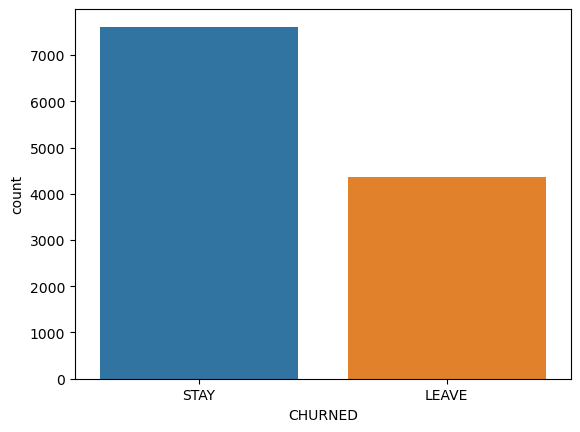

In [234]:
sns.countplot(data=train_df,x="CHURNED")
plt.show()

LESSTHAN600k : La valeur de l'habitation est-elle inférieure ou supérieure à 600k 

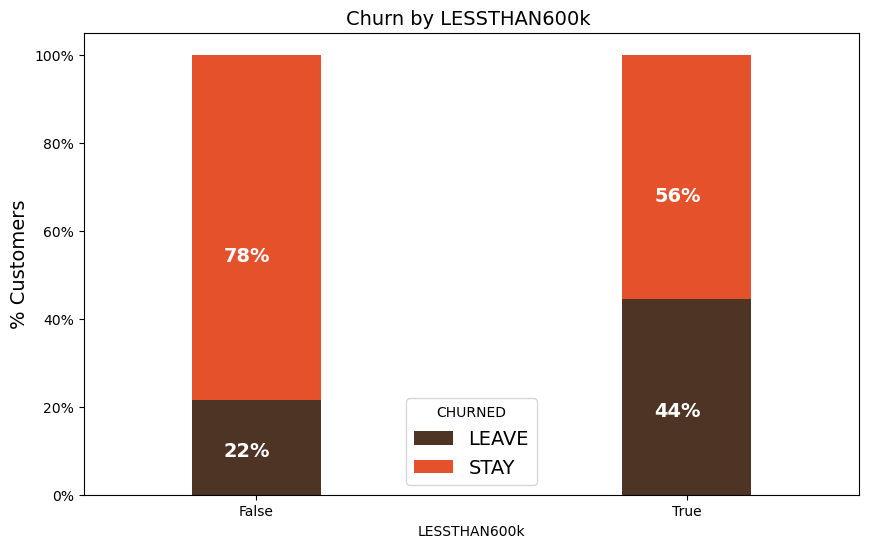

In [241]:
colors = ['#4D3425','#E4512B']
contract_churn = train_df.groupby(['LESSTHAN600k','CHURNED']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'CHURNED')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by LESSTHAN600k ',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

REPORTED_SATISFACTION : Niveau de satisfaction autodéclaré

Les clients ayant une maison d'une valeur supérieure à 600K ont tendance à rester deux fois plus souvent que de quitter
Le pourcentage de clients ayant quitté et possédant une maison d'une valeur inférieure à 600K est élevé.

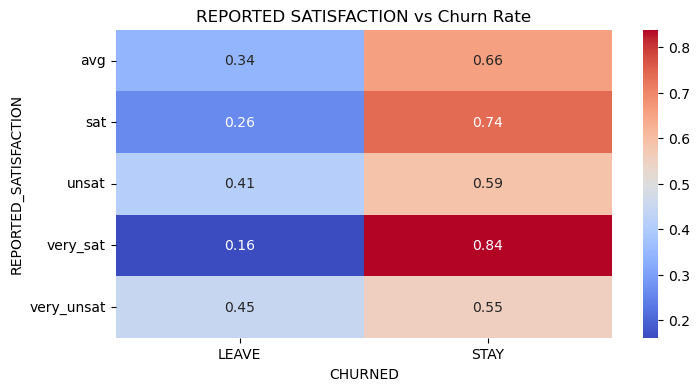

In [242]:
internet_churn = train_df.groupby('REPORTED_SATISFACTION')['CHURNED'].value_counts(normalize=True).unstack()
plt.figure(figsize=(8, 4))
sns.heatmap(internet_churn, annot=True, cmap='coolwarm')
plt.title('REPORTED SATISFACTION vs Churn Rate')
plt.show()

Les clients les plus satisfaits ont tendance à rester, tandis que ceux qui ne sont pas satisfaits ont une tendance plus marquée à quitter.

CONSIDERING_CHANGE_OF_PLAN : Considération autodéclarée de changer d'opérateur

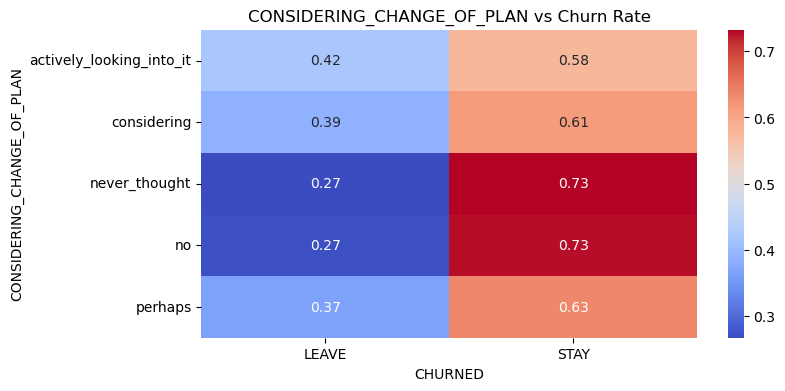

In [243]:
internet_churn = train_df.groupby('CONSIDERING_CHANGE_OF_PLAN')['CHURNED'].value_counts(normalize=True).unstack()
plt.figure(figsize=(8, 4))
sns.heatmap(internet_churn, annot=True, cmap='coolwarm')
plt.title('CONSIDERING_CHANGE_OF_PLAN vs Churn Rate')
plt.show()

Le pourcentage des clients qui restent et qui ne considèrent pas de changer d'opérateur est plus élevé que celui des clients qui envisagent de changer d'opérateur

La distribution des variables catégorielles en fonction des clients ayant ou n'ayant pas quitté l'entreprise.

<Axes: xlabel='CHURNED', ylabel='OVERCHARGE'>

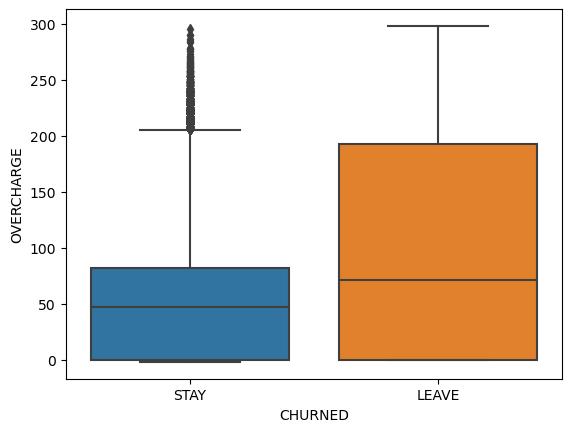

In [246]:
sns.boxplot(x = train_df.CHURNED, y = train_df.OVERCHARGE)

Pour les clients "STAY", la surfacturation semble plus concentrée autour de valeurs plus faibles, tandis que pour les clients "LEAVE", elle est répartie sur un intervalle plus large.

<Axes: xlabel='CHURNED', ylabel='REVENUE'>

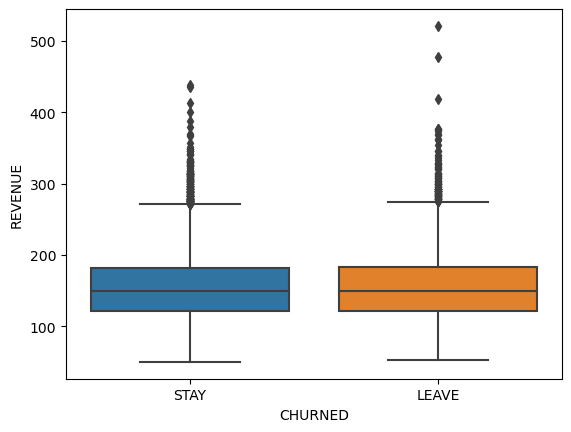

In [247]:
sns.boxplot(x = train_df.CHURNED, y = train_df.REVENUE)

Les médianes des revenus pour les deux groupes sont assez similaires, ce qui suggère que le revenu moyen des clients qui quittent n'est pas significativement différent de celui des clients qui restent.

JOB_CLASS : Type d'emploi autodéclaré

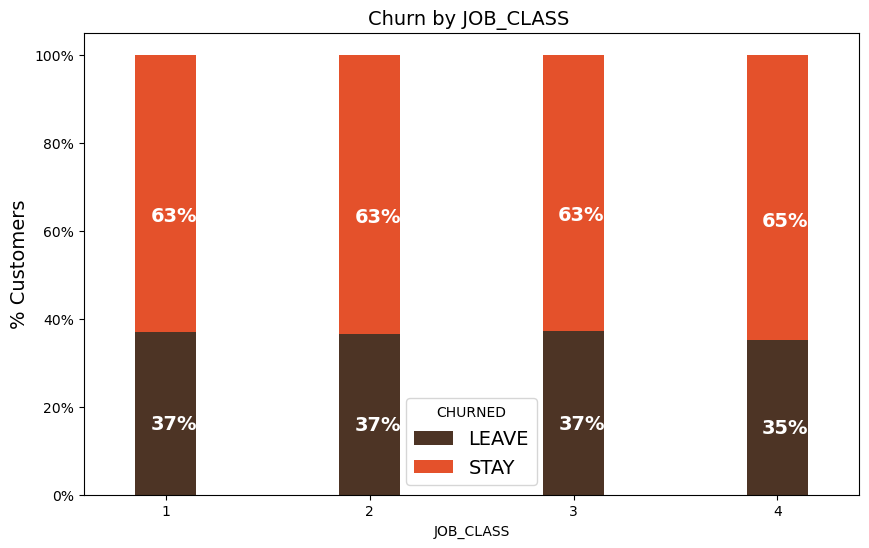

In [248]:
colors = ['#4D3425','#E4512B']
contract_churn = train_df.groupby(['JOB_CLASS','CHURNED']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = True,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.legend(loc='best',prop={'size':14},title = 'CHURNED')
ax.set_ylabel('% Customers',size = 14)
ax.set_title('Churn by JOB_CLASS ',size = 14)

# Code to add the data labels on the stacked bar chart
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0f}%'.format(height), (p.get_x()+.25*width, p.get_y()+.4*height),
                color = 'white',
               weight = 'bold',
               size = 14)

HANDSET_PRICE : Coût du téléphone

<Axes: xlabel='CHURNED', ylabel='HANDSET_PRICE'>

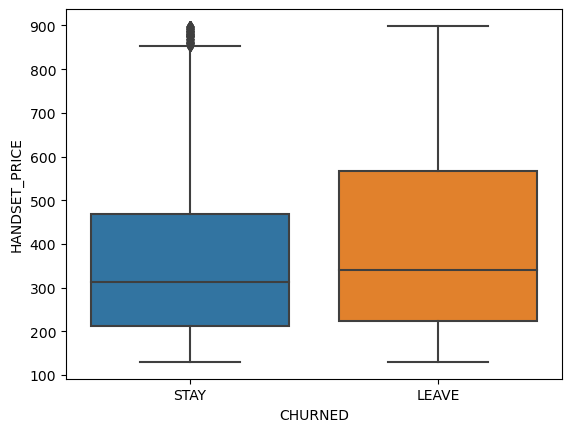

In [249]:
sns.boxplot(x = train_df.CHURNED, y = train_df.HANDSET_PRICE)

/tmp/ipykernel_21634/2280258037.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, '# of Customers by their tenure')

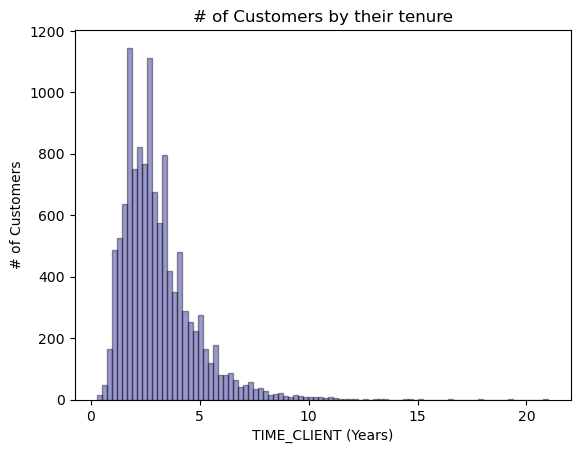

In [250]:

ax = sns.distplot(train_df['TIME_CLIENT'], hist=True, kde=False, 
             bins=int(180/2), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set_ylabel('# of Customers')
ax.set_xlabel('TIME_CLIENT (Years)')
ax.set_title('# of Customers by their tenure')

/tmp/ipykernel_21634/79088355.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 1.0, '# of Customers by their tenure')

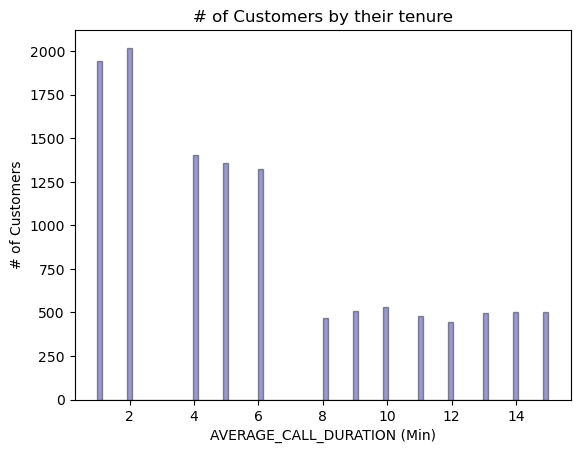

In [251]:
ax = sns.distplot(train_df['AVERAGE_CALL_DURATION'], hist=True, kde=False, 
             bins=int(180/2), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
ax.set_ylabel('# of Customers')
ax.set_xlabel('AVERAGE_CALL_DURATION (Min)')
ax.set_title('# of Customers by their tenure')

<Axes: xlabel='CHURNED', ylabel='AVERAGE_CALL_DURATION'>

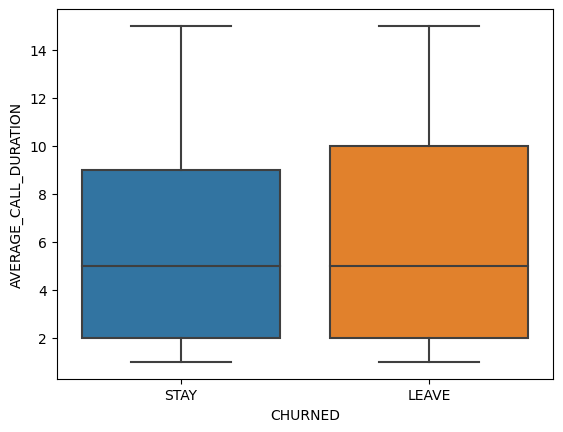

In [252]:
sns.boxplot(x = train_df.CHURNED, y = train_df.AVERAGE_CALL_DURATION)

LEFTOVER : Nombre moyen de minutes restantes par mois

<Axes: xlabel='CHURNED', ylabel='LEFTOVER'>

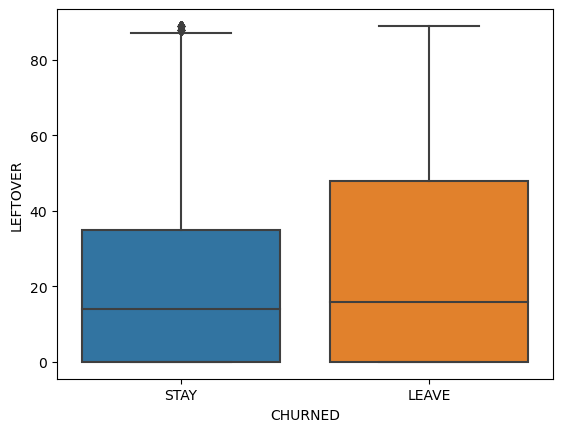

In [253]:
sns.boxplot(x = train_df.CHURNED, y = train_df.LEFTOVER)

Text(0.5, 1.0, 'Distribution of monthly charges by churn')

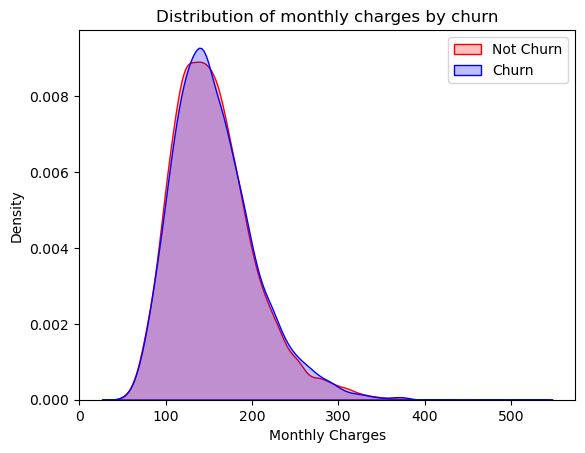

In [254]:
ax = sns.kdeplot(train_df.REVENUE[(train_df["CHURNED"] == 'STAY') ],
                color="Red", fill = True)
ax = sns.kdeplot(train_df.REVENUE[(train_df["CHURNED"] == 'LEAVE') ],
                ax =ax, color="Blue", fill= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Revenue')
ax.set_title('Distribution de revenue')

In [255]:
columns=train_df.select_dtypes(include='object').columns
columns

Index(['CUSTOMER_ID', 'COLLEGE', 'REPORTED_SATISFACTION',
       'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN', 'CHURNED'],
      dtype='object')

In [256]:
le = LabelEncoder()
for column in columns:
    train_df[column] = le.fit_transform(train_df[column])

<Axes: >

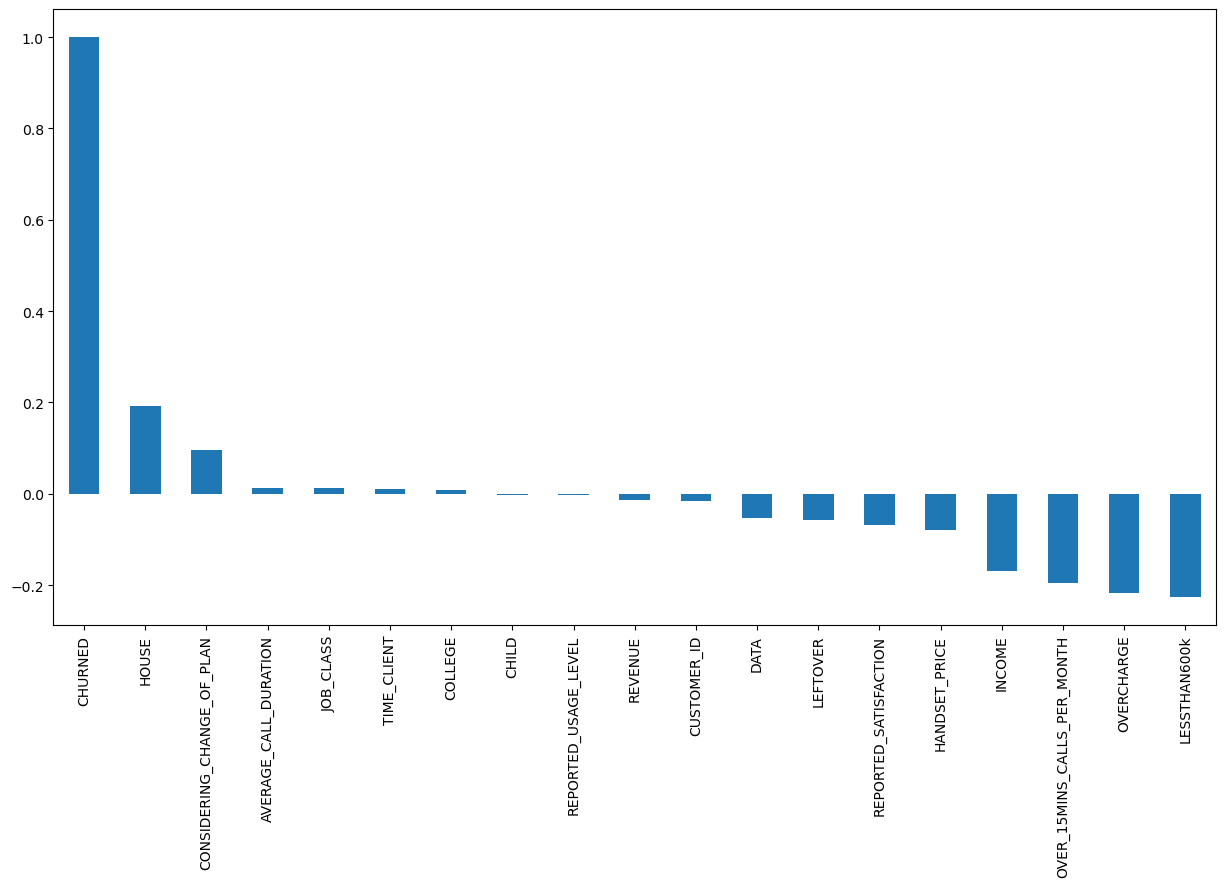

In [257]:
plt.figure(figsize=(15,8))
train_df.corr()['CHURNED'].sort_values(ascending=False).plot(kind='bar')

# Determiner les varaibles redondantes

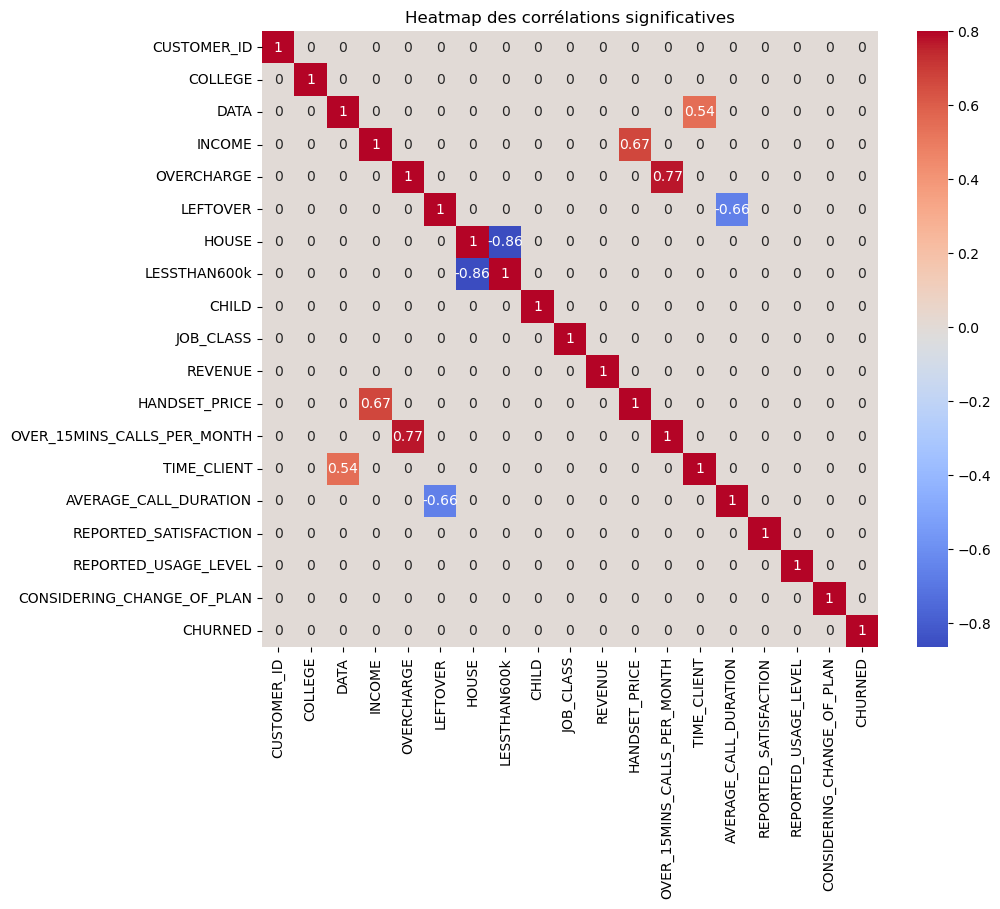

In [258]:
corr=train_df.corr()
mask = np.abs(corr) < 0.5
filtered_corr = corr.copy()
filtered_corr[mask] = 0  # Remplacer les valeurs en dessous du seuil par 0

# Afficher le heatmap avec uniquement les corrélations significatives
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, vmax=0.8, square=True, annot=True, cmap='coolwarm')
plt.title('Heatmap des corrélations significatives')
plt.show()

In [259]:
num_cols = train_df._get_numeric_data().columns
corr_matrix = train_df[num_cols].corr().abs()

threshold = 0.8
# Find features with high correlation
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold )]

# Print features to drop
print(f"The following {len(to_drop)} features will be dropped due to high correlation: {to_drop}")

The following 1 features will be dropped due to high correlation: ['LESSTHAN600k']


In [260]:
train_df = train_df.drop(to_drop, axis = 1)

In [261]:
train_df

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,0,1,660.000000,19995.0,0,0,897338.0,4,3,160.0,155,1,1.2,15,4,2,1,1
1,1,0,317.647059,31477.0,155,15,393396.0,0,1,100.0,245,27,2.7,4,2,2,1,0
2,2,1,208.695652,66742.0,0,13,937197.0,4,2,127.0,493,20,2.6,4,0,4,1,1
3,3,1,265.017668,40864.0,183,0,986430.0,3,3,86.0,390,13,2.5,12,2,3,1,0
4,4,0,440.000000,43321.5,200,0,394622.0,2,3,77.0,175,18,2.4,10,4,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,11976,0,829.787234,40567.0,41,7,458723.0,0,4,128.0,305,5,3.9,4,0,2,0,1
11977,11977,1,723.529412,75007.5,70,0,328171.0,3,1,199.0,610,5,4.1,13,2,2,0,0
11978,11978,1,80.000000,77674.5,0,80,439967.0,3,1,94.0,750,1,1.4,1,2,2,0,0
11979,11979,1,77.777778,37730.5,0,17,795808.0,3,1,142.0,284,0,1.7,8,4,2,1,1


l est souvent redondant de conserver deux variables corrélées dans notre modèle. Cela peut entraîner des problèmes tels que la multicolinéarité, où le modèle a du mal à distinguer l'effet de chaque variable.

Pour éviter cela, nous avons décidé d'éliminer les variables redondantes. Dans notre cas, nous avons choisi de supprimer la variable LESSTHAN600k.

<H2>K-means Clustering</H2>

L'objectif du clustering est de déterminer si nous pouvons regrouper nos clients en segments intéressants

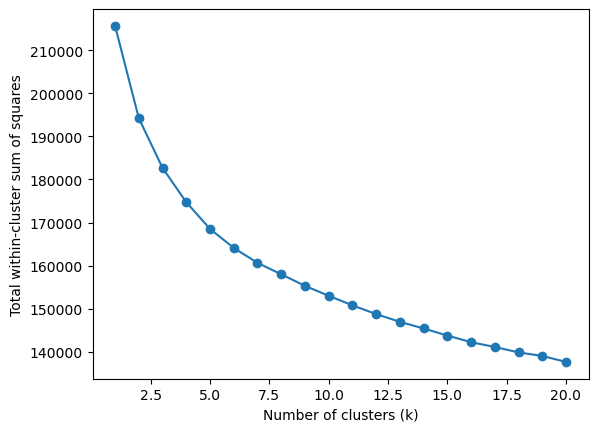

In [262]:
# K-means Clustering
data_numeric = train_df.select_dtypes(include=[np.number])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)
from sklearn.cluster import KMeans
ratios = [KMeans(n_clusters=k, n_init=20, random_state=1).fit(data_scaled).inertia_ for k in range(1, 21)]
plt.plot(range(1, 21), ratios, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Total within-cluster sum of squares')
plt.show()

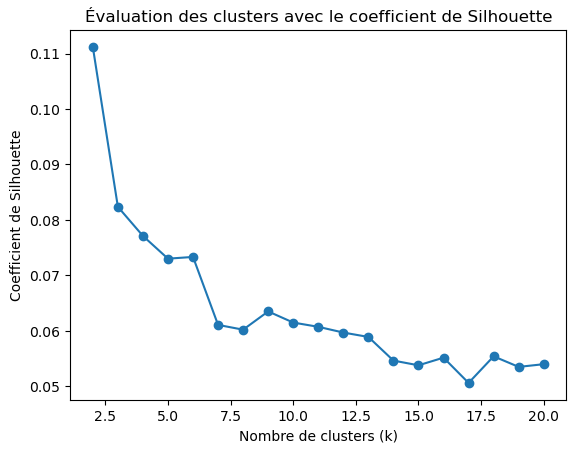

In [263]:
from sklearn.metrics import silhouette_score
k_range = range(2, 21)  # Notez que k doit être au moins 2 pour calculer la silhouette

# Liste pour stocker les scores de silhouette
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=1)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Tracer les scores de silhouette
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Coefficient de Silhouette')
plt.title('Évaluation des clusters avec le coefficient de Silhouette')
plt.show()

In [264]:
train_df

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED
0,0,1,660.000000,19995.0,0,0,897338.0,4,3,160.0,155,1,1.2,15,4,2,1,1
1,1,0,317.647059,31477.0,155,15,393396.0,0,1,100.0,245,27,2.7,4,2,2,1,0
2,2,1,208.695652,66742.0,0,13,937197.0,4,2,127.0,493,20,2.6,4,0,4,1,1
3,3,1,265.017668,40864.0,183,0,986430.0,3,3,86.0,390,13,2.5,12,2,3,1,0
4,4,0,440.000000,43321.5,200,0,394622.0,2,3,77.0,175,18,2.4,10,4,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,11976,0,829.787234,40567.0,41,7,458723.0,0,4,128.0,305,5,3.9,4,0,2,0,1
11977,11977,1,723.529412,75007.5,70,0,328171.0,3,1,199.0,610,5,4.1,13,2,2,0,0
11978,11978,1,80.000000,77674.5,0,80,439967.0,3,1,94.0,750,1,1.4,1,2,2,0,0
11979,11979,1,77.777778,37730.5,0,17,795808.0,3,1,142.0,284,0,1.7,8,4,2,1,1


In [284]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


data_numeric = train_df.select_dtypes(include=[np.number])
scaler = StandardScaler()
# Appliquer K-means avec un nombre de clusters choisi (par exemple, 3)
kmeans = KMeans(n_clusters=3, n_init=20, random_state=42)
clusters = kmeans.fit_predict(data_numeric)

# Ajouter les informations de cluster à X_train
X_train_with_clusters = pd.DataFrame(train_df)
X_train_with_clusters['cluster'] = clusters

In [285]:
X_train_with_clusters

,CUSTOMER_ID,COLLEGE,DATA,INCOME,OVERCHARGE,LEFTOVER,HOUSE,CHILD,JOB_CLASS,REVENUE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,TIME_CLIENT,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURNED,cluster
0,0,1,660.000000,19995.0,0,0,897338.0,4,3,160.0,155,1,1.2,15,4,2,1,1,0
1,1,0,317.647059,31477.0,155,15,393396.0,0,1,100.0,245,27,2.7,4,2,2,1,0,2
2,2,1,208.695652,66742.0,0,13,937197.0,4,2,127.0,493,20,2.6,4,0,4,1,1,0
3,3,1,265.017668,40864.0,183,0,986430.0,3,3,86.0,390,13,2.5,12,2,3,1,0,0
4,4,0,440.000000,43321.5,200,0,394622.0,2,3,77.0,175,18,2.4,10,4,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11976,11976,0,829.787234,40567.0,41,7,458723.0,0,4,128.0,305,5,3.9,4,0,2,0,1,2
11977,11977,1,723.529412,75007.5,70,0,328171.0,3,1,199.0,610,5,4.1,13,2,2,0,0,1
11978,11978,1,80.000000,77674.5,0,80,439967.0,3,1,94.0,750,1,1.4,1,2,2,0,0,2
11979,11979,1,77.777778,37730.5,0,17,795808.0,3,1,142.0,284,0,1.7,8,4,2,1,1,0


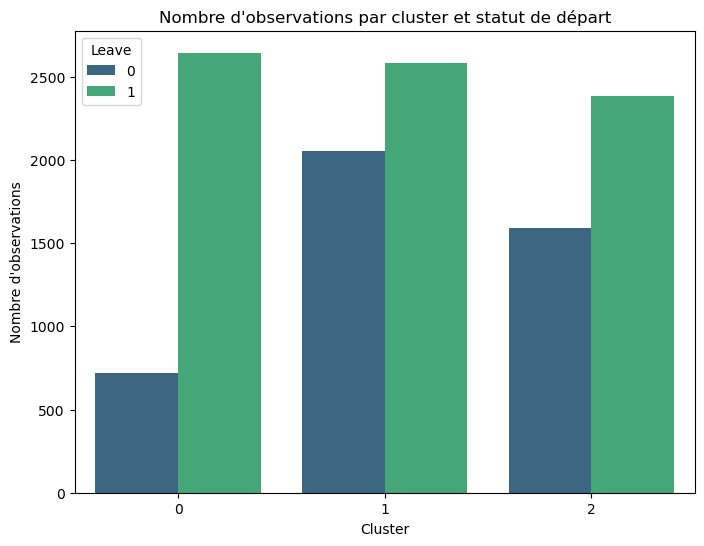

In [286]:
# Création du graphique
plt.figure(figsize=(8, 6))
sns.countplot(data=X_train_with_clusters, x='cluster', hue='CHURNED', palette='viridis')

# Personnalisation du graphique
plt.title('Nombre d\'observations par cluster et statut de départ')
plt.xlabel('Cluster')
plt.ylabel('Nombre d\'observations')
plt.legend(title='Leave')
plt.show()

In [287]:
lb = LabelBinarizer()
X_train_with_clusters['CHURNED'] = lb.fit_transform(X_train_with_clusters['CHURNED']).ravel() 
correlation = X_train_with_clusters[['cluster', 'CHURNED']].corr().iloc[0, 1]
print(f"Corrélation entre les clusters et la variable cible : {correlation:.2f}")


Corrélation entre les clusters et la variable cible : -0.14


Après observation et analyse de la corrélation, nous trouvons que les clusters produits par K-means ne fournissent aucune signification ou séparation utile pour la variable CHURNED 

In [269]:

def load_and_preprocess_data(train_df, test_df): 
    categorical_cols = ['COLLEGE', 'JOB_CLASS', 'REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL', 'CONSIDERING_CHANGE_OF_PLAN']
    numerical_cols = ['DATA', 'INCOME', 'OVERCHARGE', 'LEFTOVER', 'HOUSE', 'CHILD', 'REVENUE', 'HANDSET_PRICE', 'OVER_15MINS_CALLS_PER_MONTH', 'TIME_CLIENT', 'AVERAGE_CALL_DURATION']
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)])
    
    # Séparer les caractéristiques et la cible
    X = train_df.drop(columns=['CUSTOMER_ID', 'CHURNED'])
    y = train_df['CHURNED']

    # Diviser en ensembles d'entraînement et de test
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Prétraiter les données
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)
    X_test = preprocessor.transform(test_df.drop(columns=['CUSTOMER_ID']))
    
    # Récupérer les identifiants des clients pour l'ensemble de test
    test_ids = test_df['CUSTOMER_ID']
    
    return X_train, X_valid, y_train, y_valid, X_test, test_ids

# Exemple d'utilisation
# Assurez-vous que train_df et test_df sont déjà définis comme DataFrames pandas
X_train, X_valid, y_train, y_valid, X_test, test_ids = load_and_preprocess_data(X_train_with_clusters, test_df)

<H2>Model Training</H2>

Aprés nous évaluons plusieurs modèles de classification pour déterminer celui qui offre les meilleures performances pour prédire la variable cible. Nous avons sélectionné cinq modèles différents : 
la régression logistique,
la forêt aléatoire, 
l'arbre de décision, 
la machine à vecteurs de support (SVM), 
le boosting par gradient

Logistic Regression: Training ROC AUC = 0.7740, Validation ROC AUC = 0.7450
Random Forest: Training ROC AUC = 1.0000, Validation ROC AUC = 0.8301
Decision Tree: Training ROC AUC = 1.0000, Validation ROC AUC = 0.6718
SVM: Training ROC AUC = 0.8885, Validation ROC AUC = 0.8141
Gradient Boosting: Training ROC AUC = 0.8815, Validation ROC AUC = 0.8421


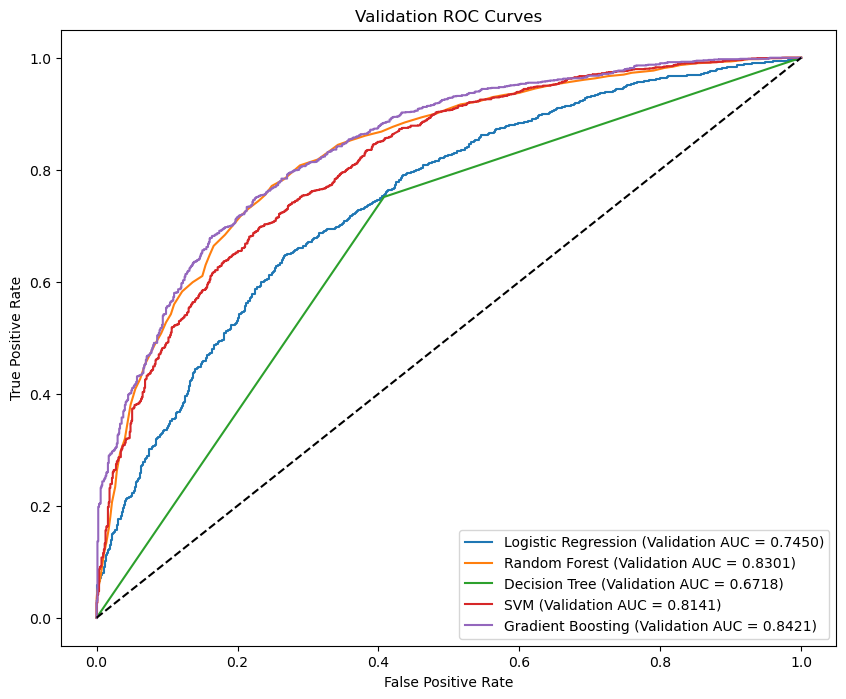

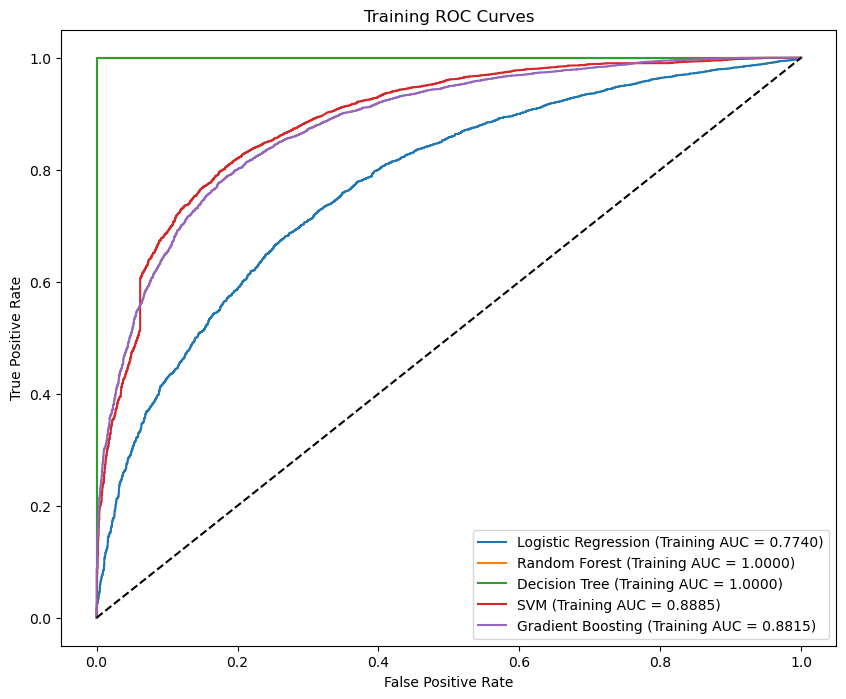

In [270]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np

# Convertir les étiquettes en valeurs binaires
lb = LabelBinarizer()
y_valid_binary = lb.fit_transform(y_valid).ravel()  # Convertir y_valid en valeurs binaires (0, 1)
y_train_binary = lb.transform(y_train).ravel()  # Convertir y_train en valeurs binaires (0, 1)

# Liste des modèles à tester
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Dictionnaire pour stocker les résultats
results = {}

# Entraîner et évaluer chaque modèle
for name, model in models.items():
    model.fit(X_train, y_train)
    
    # Prédictions de probabilité sur l'ensemble de validation
    y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # Calcul des scores AUC
    valid_auc = roc_auc_score(y_valid_binary, y_valid_pred_proba)
    train_auc = roc_auc_score(y_train_binary, y_train_pred_proba)
    
    # Courbes ROC
    valid_fpr, valid_tpr, _ = roc_curve(y_valid_binary, y_valid_pred_proba)
    train_fpr, train_tpr, _ = roc_curve(y_train_binary, y_train_pred_proba)
    
    results[name] = {
        'model': model,
        'valid_auc': valid_auc,
        'train_auc': train_auc,
        'valid_fpr': valid_fpr,
        'valid_tpr': valid_tpr,
        'train_fpr': train_fpr,
        'train_tpr': train_tpr
    }

# Afficher les scores AUC
for name, result in results.items():
    print(f'{name}: Training ROC AUC = {result["train_auc"]:.4f}, Validation ROC AUC = {result["valid_auc"]:.4f}')

# Tracer les courbes ROC pour l'ensemble de validation
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['valid_fpr'], result['valid_tpr'], label=f'{name} (Validation AUC = {result["valid_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation ROC Curves')
plt.legend()
plt.show()

# Tracer les courbes ROC pour l'ensemble d'entraînement
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['train_fpr'], result['train_tpr'], label=f'{name} (Training AUC = {result["train_auc"]:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curves')
plt.legend()
plt.show()


Les deux modèles forêt Aléatoire et Arbre de Décision montrent une performance parfaite sur l'ensemble d'entraînement (ROC AUC = 1.0000), mais une performance beaucoup plus faible sur l'ensemble de validation. Cela indique un overfitting La courbe ROC du Gradient Boosting démontre une aire sous la courbe (AUC) supérieure par rapport aux autres modèles

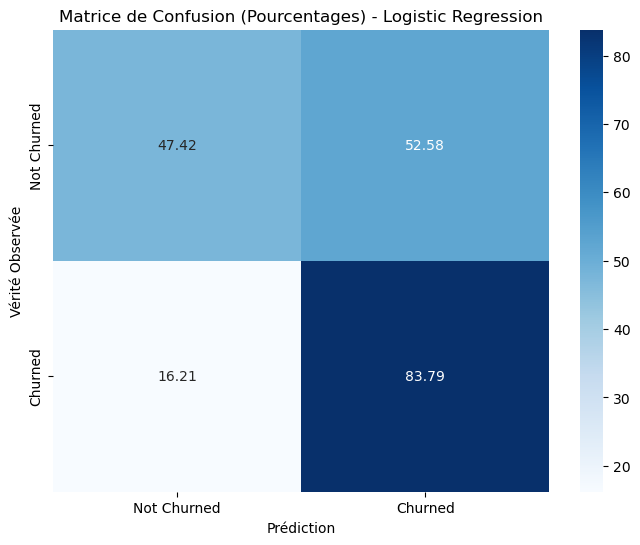

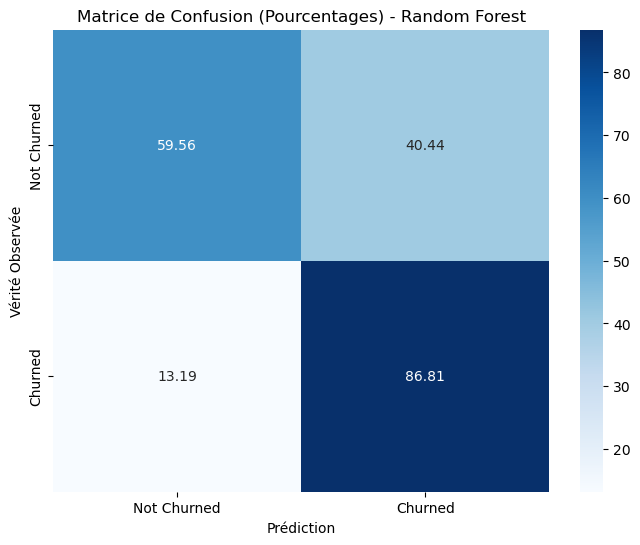

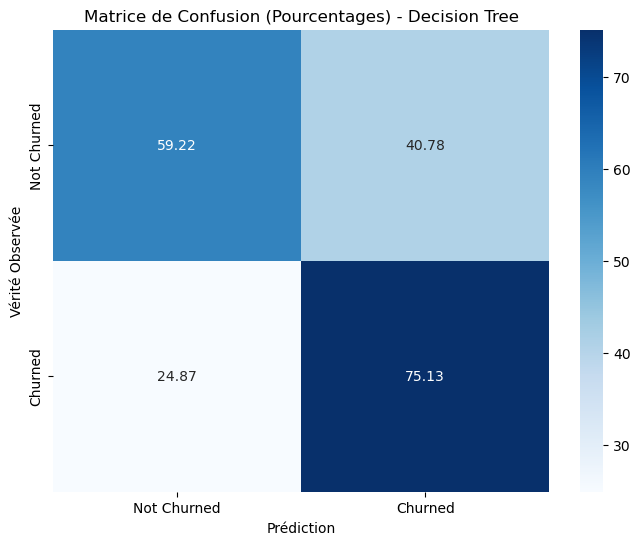

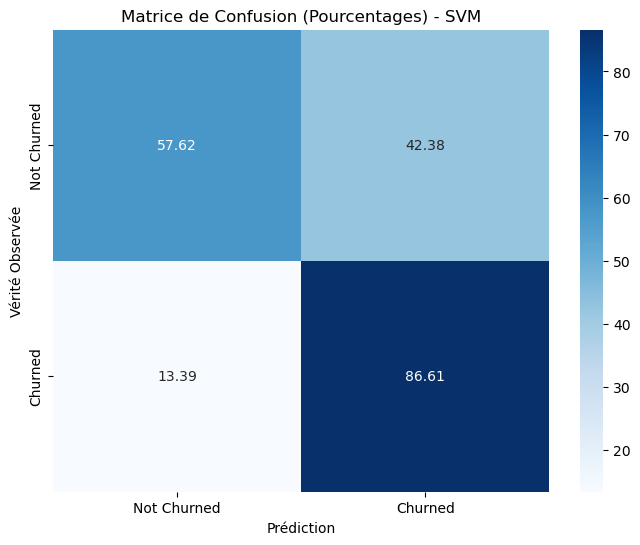

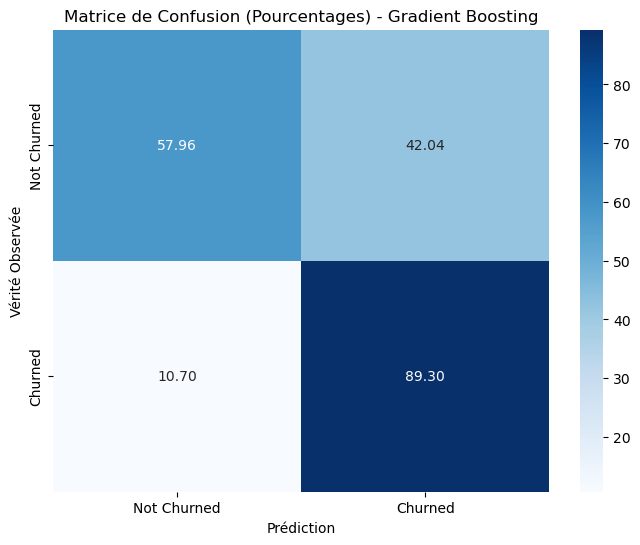

In [283]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_valid, y_pred)
    
    # Normalisation des valeurs de la matrice de confusion pour afficher les pourcentages
    conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', 
                xticklabels=['Not Churned', 'Churned'], yticklabels=['Not Churned', 'Churned'])
    plt.title(f'Matrice de Confusion (Pourcentages) - {name}')
    plt.xlabel('Prédiction')
    plt.ylabel('Vérité Observée')
    plt.show()

La matrice de confusion révèle que le modèle de Gradient Boosting permet une précision optimale dans la classification des instances positives et négatives.

La ROC AUC du modèle Gradient Boosting est de 0.8421, ce qui indique une excellente discrimination entre les classes. Avec 506 cas négatifs et 1361 cas positifs bien classés, il est le meilleur choix pour prédire le désabonnement des clients.

Après une analyse approfondie des performances de plusieurs modèles de classification pour prédire le churn des clients de TELCO Inc., le modèle de Gradient Boosting a été sélectionné comme le meilleur

In [272]:
def predict(model, X_test):
    return model.predict_proba(X_test)[:, 1]
predictions = predict(models['Gradient Boosting'], X_test)


In [273]:
def should_contact_client(churn_probability, revenue, cost_to_contact=10):
    churn_label = 'LEAVE' if churn_probability > 0.5 else 'STAY'
    
    if churn_label == 'LEAVE':
        expected_loss = revenue * churn_probability
        
        if expected_loss > 10:
            # Calcul de la réduction
            max_discount = min(expected_loss - cost_to_contact, revenue * 0.5)
            return 'YES', max_discount
        
    return 'NO', 0

discounts = []
contact_decisions = []

for i in range(len(test_ids)):
    churn_probability = predictions[i]
    revenue = test_df.at[i, 'REVENUE']
    
    contact_decision, discount = should_contact_client(churn_probability, revenue)
    
    contact_decisions.append(contact_decision)
    discounts.append(discount)

In [274]:
output_df = pd.DataFrame({
    'CUSTOMER_ID': test_ids,
    'CHURN_PROBABILITY': predictions,
    'CHURN_LABEL': ['LEAVE' if prob > 0.5 else 'STAY' for prob in predictions],
    'CLIENT_TO_CONTACT': contact_decisions,
    'DISCOUNT': discounts
})


output_path = '/home/aicha/Bureau/stage/telco-churn-prediction/data/ranked_customers.csv'
output_df.to_csv(output_path, index=False)
print(f'Résultats sauvegardés dans {output_path}')

Résultats sauvegardés dans /home/aicha/Bureau/stage/telco-churn-prediction/data/ranked_customers.csv


In [275]:
output_df

,CUSTOMER_ID,CHURN_PROBABILITY,CHURN_LABEL,CLIENT_TO_CONTACT,DISCOUNT
0,C100002,0.578077,LEAVE,YES,74.5
1,C100003,0.482227,STAY,NO,0.0
2,C100004,0.732804,LEAVE,YES,62.0
3,C100005,0.786206,LEAVE,YES,139.5
4,C100007,0.962614,LEAVE,YES,64.0
...,...,...,...,...,...
3988,C115959,0.712856,LEAVE,YES,84.0
3989,C115961,0.347853,STAY,NO,0.0
3990,C115962,0.803478,LEAVE,YES,57.5
3991,C115969,0.674130,LEAVE,YES,73.0


<H1>Conclution:</H1>
Après une analyse approfondie des performances de divers modèles de classification pour prédire le churn des clients de TELCO . le modèle de Gradient Boosting a été retenu comme le plus performant. La matrice de confusion et la courbe ROC indiquent que ce modèle atteint une précision optimale dans la classification des instances positives et négatives.